In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from PIL import Image

from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Dense, Dropout, Lambda,
                                     Reshape, BatchNormalization, LSTM, Activation,
                                     concatenate, MaxPooling1D, UpSampling1D,
                                     Conv1D, Conv1DTranspose, Flatten, Input)
from tensorflow.keras.losses import MAE
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from google.colab import files

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
oil = pd.read_csv('/content/drive/MyDrive/UAI/Data_CSV/Brent.csv', header=None)
oil.head()

,0,1,2,3,4,5,6
0,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
1,20.05.2016,"48,72","48,90","49,39","48,07","255,58K","-0,18%"
2,23.05.2016,"48,35","48,72","48,84","47,58","225,09K","-0,76%"
3,24.05.2016,"48,61","48,35","49,24","47,80","211,58K","0,54%"
4,25.05.2016,"49,74","49,16","49,96","48,91","237,79K","2,32%"


In [16]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1313 non-null   object
 1   1       1313 non-null   object
 2   2       1313 non-null   object
 3   3       1313 non-null   object
 4   4       1313 non-null   object
 5   5       1313 non-null   object
 6   6       1313 non-null   object
dtypes: object(7)
memory usage: 71.9+ KB


In [18]:
# oil.drop(['Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'], axis=1, inplace=True)
# Удаляем названия столбцов и не нужные колонки
oil.drop(oil.columns[2:], axis=1, inplace=True)
oil.drop(oil.columns[0], axis=0, inplace=True)
oil.head()

,0,1
1,20.05.2016,"48,72"
2,23.05.2016,"48,35"
3,24.05.2016,"48,61"
4,25.05.2016,"49,74"
5,26.05.2016,"49,59"


In [20]:
# параметры
oil_data = oil.iloc[:,1]
print(f' Количество записей: {len(oil_data)} \n Длина одной строки: {len(oil_data.iloc[0])} \n Первое значение: {oil_data.iloc[0]}')

 Количество записей: 1312 
 Длина одной строки: 5 
 Первое значение: 48,72


In [21]:
# В numpy массив
oil_array = np.array(oil_data)
for i  in range(len(oil_array)):
    oil_array[i] = float(oil_array[i].replace(',', ''))

Загружаем Данные

In [22]:
# Параметры загрузки данных
X_len = 60      # анализ по 60 точкам
val_len = 300   # количество проверочных записей
train_len = oil_array.shape[0] - val_len   # тренировочная выборка

# Делим на Train и Test
X_train, X_test = np.reshape(oil_array[:train_len], (-1, 1)), np.reshape(oil_array[train_len + X_len +2:],(-1, 1))

# Масштабируем данные X_train, X_test
Scaler = MinMaxScaler()
Scaler.fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)

# генератор обучения
X_train_gen = TimeseriesGenerator(X_train, X_train, length=X_len, sampling_rate=1, batch_size=16)
# генератор валидации
X_test_gen = TimeseriesGenerator(X_test, X_test, length=X_len, sampling_rate=1, batch_size=16)


Отображение результатов

In [23]:
# Функция расчета результатов прогнозирования сети. В аргументы принимает сеть - curr_model и X_test.
# Выдает результаты предсказания - pred_val и правильные ответы в исходной размерности val_unscaled

def get_predict(curr_model, X_val, y_val, y_scaler):
    pred_val = y_scaler.inverse_transform(curr_model.predict(X_val))   # Предсказание по проверочной выборке
    val_unscaled = y_scaler.inverse_transform(y_val)   # возвращаем исходный масштаб данных

    return (pred_val, val_unscaled)


In [63]:
# Визиализация предсказания сети
def show_predict(start, step, channel, pred_val, val_unscaled):
    plt.figure(figsize=(16, 8))
    plt.plot(pred_val[start:start+step, channel], color='orange', label='Прогноз')
    plt.plot(val_unscaled[start:start+step, channel], color='purple', label='База')
    plt.title('График предсказания сети', fontsize=16)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Цена', fontsize=12)
    plt.legend()

    plt.show()

In [25]:
# Расчет корреляции
def correlate(a, b):
    a_mean = a.mean()          # среднее первый вектор
    b_mean = b.mean()          # среднее второй вектор
    ab_mean = (a * b).mean()   # среднее произведения векторов
    a_std = a.std()            # стандартное отклонение первого вектора
    b_std = b.std()            # стандартное отклонение второго вектора
    # Корреляция
    val = 0
    if ((a_std > 0) & (b_std > 0)):
        val = (ab_mean - a_mean * b_mean) / (a_std * b_std)

    return  val    

In [61]:
# Визиализация корреляции прогназированного сигнала с реальным, со смещениее на несколько
# шагов, для проверки появления автокорреляции
def auto_corr(channels, corr_steps, pred_val, val_unscaled, show_graf=True, return_data=False):
    for ch in channels:
        corr = []
        val_unscaled_len = val_unscaled.shape[0]

        for i in range(corr_steps):   # постепенно увеличивае шаг смещения, проверки автокорреляции
            corr.append(correlate(val_unscaled[:val_unscaled_len - i, ch], pred_val[i:, ch])) # рассчитываем и добавляем в список

        bias_corr = []   # пустой лист для корреляций со смещением на i
        for i in range(corr_steps):
            bias_corr.append(correlate(val_unscaled_len[:val_unscaled_len - i, ch], val_unscaled[i:, ch]))

    # Отображаем график для данного шага
        if show_graf:
            plt.figute(figsize=(16, 8))
            plt.plot(corr, color='orange', label=f'Предсказание на {str(ch+1)} шаг')
            plt.plot(bias_corr, color='purple', label='Эталон')

    if show_graf:
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.legend()
        plt.show()

    if return_data:            # если необходимо вернуть массивы автокорреляции
        return corr, bias_corr   


Создаем проверочную выборку

In [28]:
# Генератор проверочной выборки
val_gen = TimeseriesGenerator(X_test, X_test, length = X_len, 
                              sampling_rate=1,
                              batch_size=len(X_test))

X_val = []
y_val = []
for v in val_gen:
    X_val.append(v[0])
    y_val.append(v[1])

X_val = np.array(X_val)
y_val = np.array(y_val)


In [29]:
# Создаем нейронку LSTM
model = Sequential([
                    LSTM(32, return_sequences=True, input_shape=(X_len, 1)),
                    #LSTM(16, return_sequences=False),
                    #BatchNormalization(),
                    Dropout(0.5),
                    LSTM(16, return_sequences=True),
                    Dense(8, activation='relu'),
                    #BatchNormalization(),
                    Dropout(0.2),
                    Dense(4, activation='relu'),
                    Flatten(),
                    Dense(1, activation='linear')
                    ])


In [30]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 16)            3136      
_________________________________________________________________
dense (Dense)                (None, 60, 8)             136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 8)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 4)             36        
_________________________________________________________________
flatten (Flatten)            (None, 240)               0

In [32]:
history = model.fit(X_train_gen, epochs=100, batch_size=32, validation_data=val_gen, verbose=1)

Epoch 1/100
60/60 [==============================] - 10s 19ms/step - loss: 0.1990 - val_loss: 0.0775
Epoch 2/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0461 - val_loss: 0.0093
Epoch 3/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0335 - val_loss: 0.0125
Epoch 4/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0337 - val_loss: 0.0096
Epoch 5/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0334 - val_loss: 0.0120
Epoch 6/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0081
Epoch 7/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0309 - val_loss: 0.0083
Epoch 8/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0291 - val_loss: 0.0140
Epoch 9/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0277 - val_loss: 0.0111
Epoch 10/100
60/60 [==============================] - 0s 8ms/step - loss: 0.0256 - val_loss: 0.0097
Epoch 1

In [33]:
# Минимальная ошибка на обучающей и проверочной выборе
print(f' Минимальная ошибка на обучающей выборе: {min(history.history["loss"])} \
\n Минимальная ошибка на проверочной выборе: {min(history.history["val_loss"])}')

 Минимальная ошибка на обучающей выборе: 0.006551727652549744 
 Минимальная ошибка на проверочной выборе: 0.001579759642481804


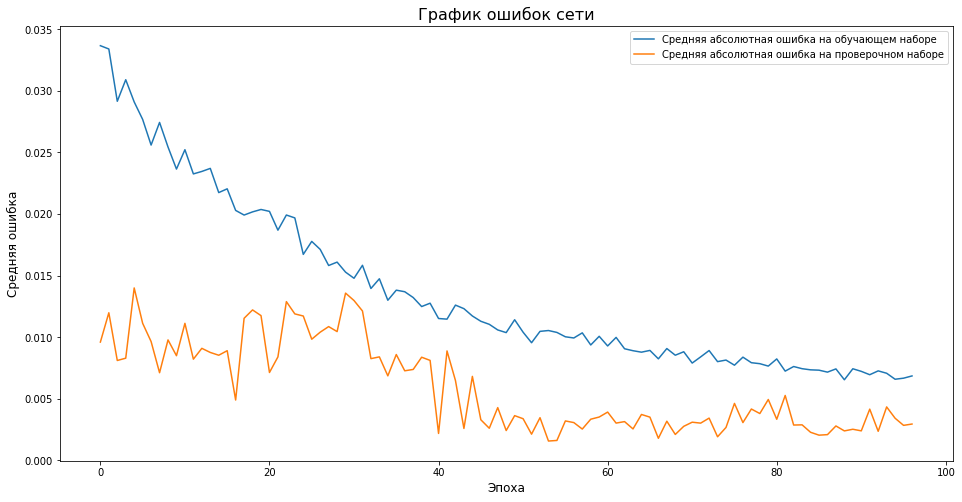

In [59]:
# График ошибок
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'][3:], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][3:], label='Средняя абсолютная ошибка на проверочном наборе')
plt.title('График ошибок сети', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Средняя ошибка', fontsize=12)
plt.legend()
plt.show()

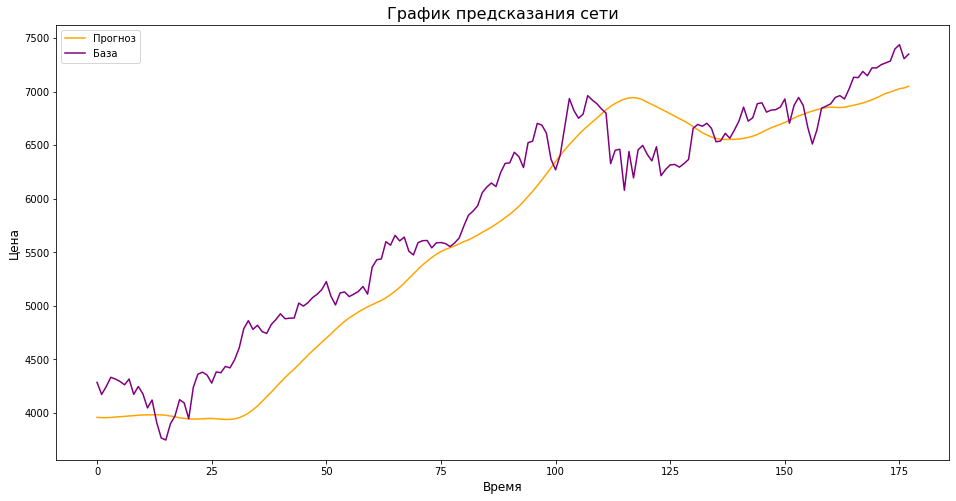

In [64]:
# Прогнозируем данные текущей сетью
curr_model = model   #Выбираем текущую модель
(pred_val, Val_unscaled) = get_predict(curr_model, X_val[0], y_val[0], Scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, pred_val, Val_unscaled)

Создаем Сеть GA

In [36]:
def create_ganet(params):
  model = Sequential()             # Создаем моель Sequential
  
  makeFirstNormalization = params[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** params[1]      # Размер первого вёрточного слоя
  firstConvKernel = params[2]         # Ядро первого свёрточного слоя
  activation0 = params[3]             # Функция активации входного слоя
  makeMaxPooling0 = params[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = params[5]         # Размер MaxPooling

  makeSecondConv = params[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** params[7]     # Размер второго свёрточного слоя
  secondConvKernel = params[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = params[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = params[10]        # Размер MaxPooling
  activation1 = params[11]            # Функция активации

  makeThirdConv = params[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** params[13]     # Размер второго свёрточного слоя
  thirdConvKernel = params[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = params[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = params[16]        # Размер MaxPooling
  activation2 = params[17]            # Функция активации

  activation3 = params[18]            # Функция активации для 
  activation4 = params[19]            # Функция активации для последнего слоя

  makeSecondNormalization = params[20] # Делаем ли финальную нормализацию
  denseSize = 2 ** params[21]          # Размер полносвязного слоя

  activation_list = ['linear','relu','tanh','softmax','sigmoid'] 

  if (makeFirstNormalization):      # Если делаем нормализацию в начале

    # Добавляем слой BatchNormalization
    model.add(BatchNormalization(input_shape=(X_len, 1))) 

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(X_len, 1), activation=activation_list[activation0], padding='same')) 

  if makeMaxPooling0:               # Если делаем maxpooling
    model.add(MaxPooling1D(maxPoolingSize0))


  if (makeSecondConv):              # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    
    if (makeMaxPooling1):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 


  if (makeThirdConv):               # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 

    if (makeMaxPooling2):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 
          
  if (makeSecondNormalization):     # Если делаем финальную нормализацию
    model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  
  model.add(Flatten())              # Добавляем слой Flatten

  model.add(Dense(denseSize, activation=activation_list[activation3])) # Добавляем слой Dense с denseSize нейронами
  model.add(Dense(1, activation=activation_list[activation4]))         # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  
  return model                      # Возвращаем модель

In [37]:
# Результаты работы сети
def evalute_params(params, ep):
    val = 0
    time.time()
    model_ganet = create_ganet(params) # Создаем модель createConvNet

  # Компилируем модель
    model_ganet.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

    history_ganet = model_ganet.fit(X_train_gen,
                    epochs=5, 
                    verbose=1,
                    validation_data=X_test_gen)
    
    val = history_ganet.history["val_loss"][-1] # Возвращаем точность на проверочной выборке с последней эпохи
  
    return val, model_ganet                     # Возвращаем точность

In [42]:
# Создание списка случайных параметров
def create_random_params():
    params = []

    params.append(random.randint(0, 1))   
    params.append(random.randint(2, 12))  
    params.append(random.randint(3, 7))   
    params.append(random.randint(0, 4))  
    params.append(random.randint(0, 1))   
    params.append(random.randint(2, 3))   
    
    params.append(random.randint(0, 1))   
    params.append(random.randint(3, 12))  
    params.append(random.randint(3, 7))   
    params.append(random.randint(0, 1))   
    params.append(random.randint(2, 3))   
    params.append(random.randint(0, 4))   

    params.append(random.randint(0, 1))   
    params.append(random.randint(3, 12))  
    params.append(random.randint(3, 7))   
    params.append(random.randint(0, 1))   
    params.append(random.randint(2, 3))   
    params.append(random.randint(0, 4))   

    params.append(random.randint(0, 4))   
    params.append(random.randint(0, 2))   
    params.append(random.randint(0, 1))   
    params.append(random.randint(3, 12)) 

    return params


GA

In [43]:
# Параметры GA
n = 20                   # Число ботов
nsurv = 10               # Количество выживших
new_surv = n - nsurv     # Количество новых ботов
ln = 22                  # Размер бота
epochs = 10              # Количество эпох

mut = 0.1                # коэфициент мутаций

popul = []               # Популяция
val = []                 # Массив значений ботов

#Создаём случайных ботов
for i in range(n):
    popul.append(create_random_params())
  
for it in range(epochs):   
                       
    val = []                              
    curr_time = time.time()
    for i in range(n):                    
        bot = popul[i]                         # Очередной бот
        f, model_sum = evalute_params(bot, 3)  # Точность текущего бота
        val.append(f)                          # Добавляем полученное значение в список val
  
    sval = sorted(val, reverse=0)             
  # Выводим 5 лучших ботов
    print(it, time.time() - curr_time, ' ', sval[0:5], popul[:5]) 
  
    new_popul = []                             # Пустой список под новую популяцию
    for i in range(nsurv):                
        index = val.index(sval[i])             # Получаем индекс очередного бота из списка лучших в списке val
        new_popul.append(popul[index])         # Добавляем в новую популяцию бота из popul
    
    for i in range(new_surv):                   
        index_p1 = random.randint(0,nsurv - 1) # Случайный индекс первого родителя
        index_p2 = random.randint(0,nsurv - 1) # Случайный индекс первого родителя
        bot_p1 = new_popul[index_p1]           # Получаем первого бота-родителя по index_p1
        bot_p2 = new_popul[index_p2]           # Получаем второго бота-родителя по index_p2    
    
        new_bot = []                           # Список значений новых ботов   
        params_mut = create_random_params()    # Cлучайная сеть для мутаций
        for j in range(ln):                       
            X = 0      
            pindex = random.random()           # Случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
            if pindex < 0.5:
                X = bot_p1[j]
            else:
                X = bot_p2[j]
      
      # Устанавливаем значение бота из params_mut
            if (random.random() < mut):
                X = params_mut[j]
        
            new_bot.append(X)                  # Добавляем значение в нового бота      
        new_popul.append(new_bot)              # Добавляем бота в новую популяцию      
    popul = new_popul

Epoch 1/5
60/60 [==============================] - 1s 7ms/step - loss: 0.0325 - val_loss: 0.5011
Epoch 2/5
60/60 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.3629
Epoch 3/5
60/60 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.2448
Epoch 4/5
60/60 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.1855
Epoch 5/5
60/60 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.1378
Epoch 1/5
60/60 [==============================] - 1s 5ms/step - loss: 0.1791 - val_loss: 0.1983
Epoch 2/5
60/60 [==============================] - 0s 4ms/step - loss: 0.1718 - val_loss: 0.1983
Epoch 3/5
60/60 [==============================] - 0s 4ms/step - loss: 0.1718 - val_loss: 0.1983
Epoch 4/5
60/60 [==============================] - 0s 4ms/step - loss: 0.1718 - val_loss: 0.1983
Epoch 5/5
60/60 [==============================] - 0s 4ms/step - loss: 0.1718 - val_loss: 0.1983
Epoch 1/5
60/60 [=============

In [44]:
# Лучшие боты
print(popul) 

[[0, 11, 7, 1, 0, 3, 1, 8, 5, 0, 2, 0, 1, 5, 7, 0, 2, 1, 1, 0, 0, 6], [0, 7, 4, 1, 1, 3, 1, 8, 6, 0, 2, 0, 1, 10, 4, 1, 2, 1, 1, 2, 0, 6], [0, 7, 7, 1, 1, 3, 1, 8, 6, 0, 2, 0, 1, 10, 4, 1, 2, 1, 1, 2, 0, 6], [0, 11, 5, 1, 1, 3, 1, 7, 5, 0, 2, 0, 1, 5, 7, 0, 3, 1, 1, 0, 0, 10], [0, 11, 5, 1, 1, 3, 1, 7, 5, 0, 2, 0, 1, 5, 7, 0, 3, 1, 1, 0, 0, 6], [0, 11, 5, 0, 0, 3, 0, 8, 5, 0, 2, 4, 0, 10, 7, 1, 3, 2, 1, 2, 0, 5], [0, 7, 6, 0, 0, 3, 1, 8, 5, 1, 2, 0, 0, 10, 7, 1, 3, 2, 1, 2, 0, 5], [0, 12, 5, 0, 1, 3, 1, 7, 5, 0, 2, 0, 1, 5, 4, 0, 3, 1, 1, 0, 0, 5], [0, 6, 5, 0, 1, 3, 0, 7, 5, 0, 2, 0, 1, 5, 7, 0, 3, 1, 1, 0, 0, 5], [0, 6, 5, 1, 1, 3, 1, 8, 6, 0, 2, 0, 1, 5, 7, 0, 2, 1, 1, 0, 0, 6], [0, 11, 5, 1, 1, 3, 0, 7, 5, 0, 2, 0, 1, 5, 7, 0, 3, 1, 1, 0, 0, 5], [0, 6, 5, 0, 1, 3, 1, 8, 6, 0, 2, 0, 1, 5, 7, 0, 2, 1, 1, 0, 0, 6], [0, 7, 5, 1, 1, 3, 1, 7, 6, 0, 2, 0, 1, 5, 4, 0, 2, 1, 1, 0, 0, 6], [0, 6, 5, 1, 1, 3, 1, 7, 6, 0, 2, 0, 1, 5, 7, 0, 3, 1, 1, 0, 0, 5], [0, 7, 5, 0, 1, 3, 1, 8, 5, 0, 2, 4,

In [45]:
model_bot = create_ganet(popul[0])
model_bot.summary()

Model: "sequential_354"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_773 (Conv1D)          (None, 60, 2048)          16384     
_________________________________________________________________
conv1d_774 (Conv1D)          (None, 60, 256)           2621696   
_________________________________________________________________
conv1d_775 (Conv1D)          (None, 60, 32)            57376     
_________________________________________________________________
flatten_354 (Flatten)        (None, 1920)              0         
_________________________________________________________________
dense_708 (Dense)            (None, 64)                122944    
_________________________________________________________________
dense_709 (Dense)            (None, 1)                 65        
Total params: 2,818,465
Trainable params: 2,818,465
Non-trainable params: 0
__________________________________________

In [46]:
#Комипилируем и обучаем
model_bot.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

history_bot = model_bot.fit(X_train_gen, epochs=100, batch_size = 32, validation_data=X_test_gen)

Epoch 1/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0350 - val_loss: 0.0217
Epoch 2/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0145 - val_loss: 0.0081
Epoch 3/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 4/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 5/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 6/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 7/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 8.6177e-04
Epoch 8/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 8.2711e-04
Epoch 9/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss

In [47]:
# Минимальная ошибка на обучающей и проверочной выборе
print(f' Минимальная ошибка на обучающей выборе: {min(history_bot.history["loss"])} \
\n Минимальная ошибка на проверочной выборе: {min(history_bot.history["val_loss"])}')

 Минимальная ошибка на обучающей выборе: 0.0003058853035327047 
 Минимальная ошибка на проверочной выборе: 0.0002954798110295087


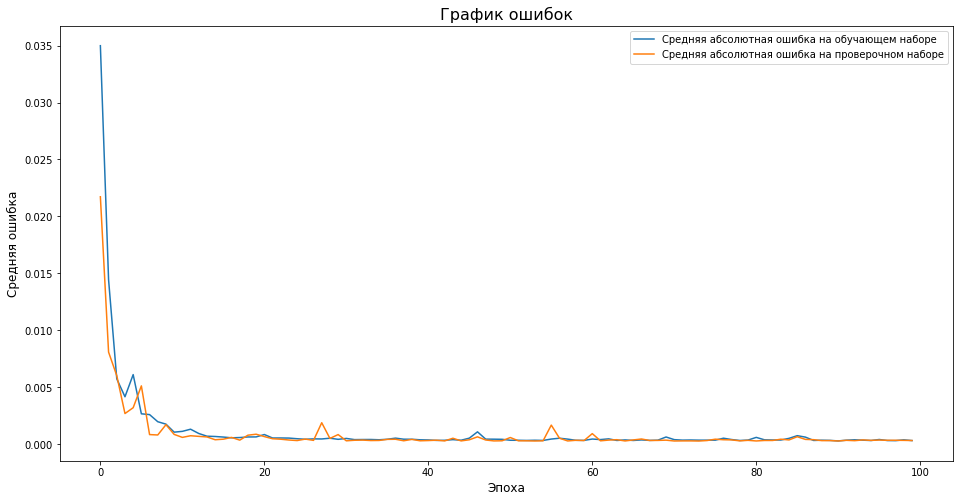

In [58]:
# График ошибок
plt.figure(figsize=(16,8))
plt.plot(history_bot.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_bot.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.title('График ошибок', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Средняя ошибка', fontsize=12)
plt.legend()
plt.show()

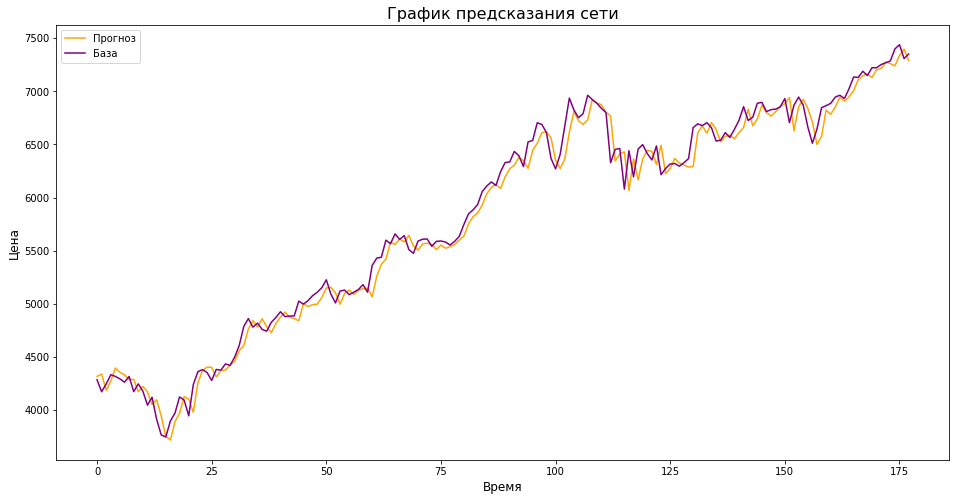

In [65]:
# Прогнозируем данные текущей сетью
curr_model = model_bot #Выбираем текущую модель
(pred_val, Val_unscaled) = get_predict(curr_model, X_val[0], y_val[0], Scaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 400, 0, pred_val, Val_unscaled)

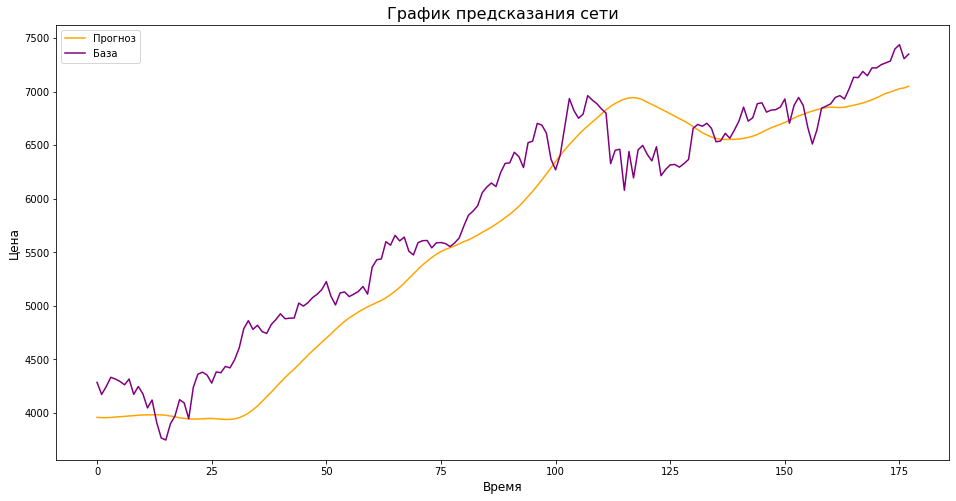

In [66]:
# Прогнозируем данные текущей сетью
curr_model = model #Выбираем текущую модель
(pred_val, val_unscaled) = get_predict(curr_model, X_val[0], y_val[0], Scaler) #Прогнозируем данные

# Отображаем графики

show_predict(0, 400, 0, pred_val, Val_unscaled)
plt.show()

Сравниваем сети

In [51]:
# Минимальная ошибка на проверочной выборе LSTM и GA
print(f' Минимальная ошибка на GA: {min(history_bot.history["loss"])} \
\n Минимальная ошибка на LSTM: {min(history.history["val_loss"])}')

 Минимальная ошибка на GA: 0.0003058853035327047 
 Минимальная ошибка на LSTM: 0.001579759642481804


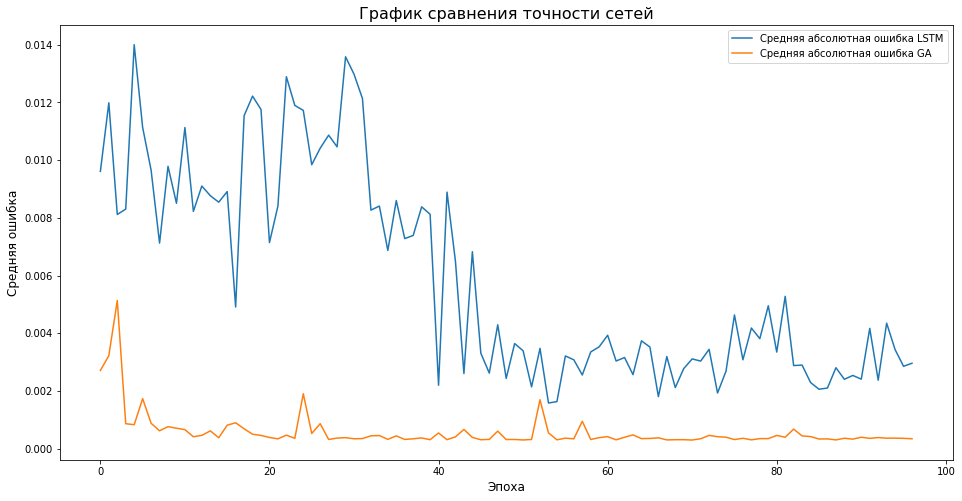

In [57]:
# График ошибок LSTM и GA
plt.figure(figsize=(16,8))
plt.plot(history.history['val_loss'][3:], label='Средняя абсолютная ошибка LSTM')
plt.plot(history_bot.history['val_loss'][3:], label='Средняя абсолютная ошибка GA')
plt.title('График сравнения точности сетей', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Средняя ошибка', fontsize=12)
plt.legend()
plt.show()